In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris

import warnings
warnings.filterwarnings('ignore')

In [2]:
class SvmVisualizer():
    """
    Class to plot the behaviour of a SVM in a dataset. 
    
    The code for this would not have been possible without the following resources:
        - https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
        - https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
        - https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html
    """
    def __init__(self, X_train, y_train, X_test, y_test, 
                 n_svm_x_axis=1, n_svm_y_axis=1, figsize=(12, 9)):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.n_svm_x_axis = n_svm_x_axis
        self.n_svm_y_axis = n_svm_y_axis
        self.plt = plt.figure(figsize=figsize)
        
        # NOTE: we should do this based on the given data, now it works because we know
        # we scaled the data
        self.xx, self.yy = np.meshgrid(np.linspace(-3, 3, 200),
                                       np.linspace(-3, 3, 200))
        self.grid = np.c_[self.xx.ravel(), self.yy.ravel()]

    def add_svm_plot(self, svm, title, k=0):
        # visualize decision function for these parameters
        plt.subplot(self.n_svm_x_axis, self.n_svm_y_axis, k + 1)
        plt.title(title, size='medium')

        # evaluate decision function in a grid
        preds = svm.predict(self.grid).reshape(self.xx.shape)
        
        # visualize parameter's effect on decision function
        plt.pcolormesh(self.xx, self.yy, preds, cmap=ListedColormap(['lightblue', 'lightcoral']), 
                       vmin=0, vmax=1)
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], label="Train data",
                    edgecolors='k', c=self.y_train, cmap=ListedColormap(['blue', 'red']))
        #plt.scatter(self.X_test[:, 0], self.X_test[:, 1], label="Test data", edgecolors='k')
        plt.xticks(())
        plt.yticks(())
        plt.tight_layout()

        # plot the decision hyperplane and support vectors
        Z = svm.decision_function(self.grid).reshape(self.xx.shape)
        plt.contour(self.xx, self.yy, Z, colors='k', levels=[-1, 0, 1], 
                    alpha=0.5, linestyles=['--', '-', '--'])
        plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100,
                    facecolors='none', zorder=10, edgecolors='k')

In [3]:
def load_iris_2d(keep="nonlinear_relationship"):
    """
    Returns the iris dataset.

    2 features:
      - Sepal length
      - Sepal width

    2 target classes:
      If keep == "nonlinear_relationship":
        - Iris versicolour as 0
        - Iris virginica as 1
      otherwise:
        - Iris setosa as 0
        - Iris versicolour as 1
    """
    iris = load_iris()
    X_2d = iris.data[:, :2]
    y_2d = iris.target

    if keep == "nonlinear_relationship":
        X_2d = X_2d[y_2d > 0]
        y_2d = y_2d[y_2d > 0]
        y_2d -= 1
    else:
        X_2d = X_2d[y_2d < 2]
        y_2d = y_2d[y_2d < 2]

    return X_2d, y_2d

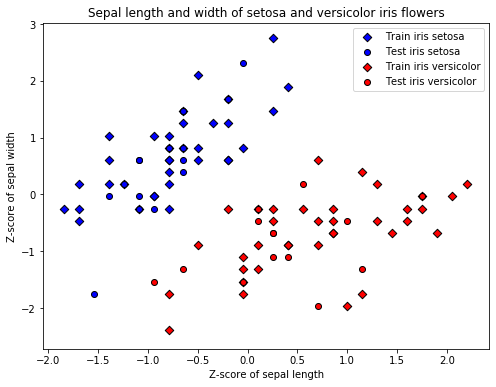

In [4]:
# Load and split the dataset
X_2d, y_2d = load_iris_2d(keep="linear_relationship")
X_train, X_test, y_train, y_test = train_test_split(X_2d, y_2d, test_size=0.3, 
                                                    random_state=8)


# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], color="b", 
            label="Train iris setosa", edgecolors='k', marker="D")
plt.scatter(X_test[y_test==0][:, 0], X_test[y_test==0][:, 1], color="b", 
            label="Test iris setosa", edgecolors='k', marker="o")
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], color="r", 
            label="Train iris versicolor", edgecolors='k', marker="D")
plt.scatter(X_test[y_test==1][:, 0], X_test[y_test==1][:, 1], color="r", 
            label="Test iris versicolor", edgecolors='k', marker="o")
plt.legend()
plt.title("Sepal length and width of setosa and versicolor iris flowers")
plt.xlabel("Z-score of sepal length")
plt.ylabel("Z-score of sepal width");

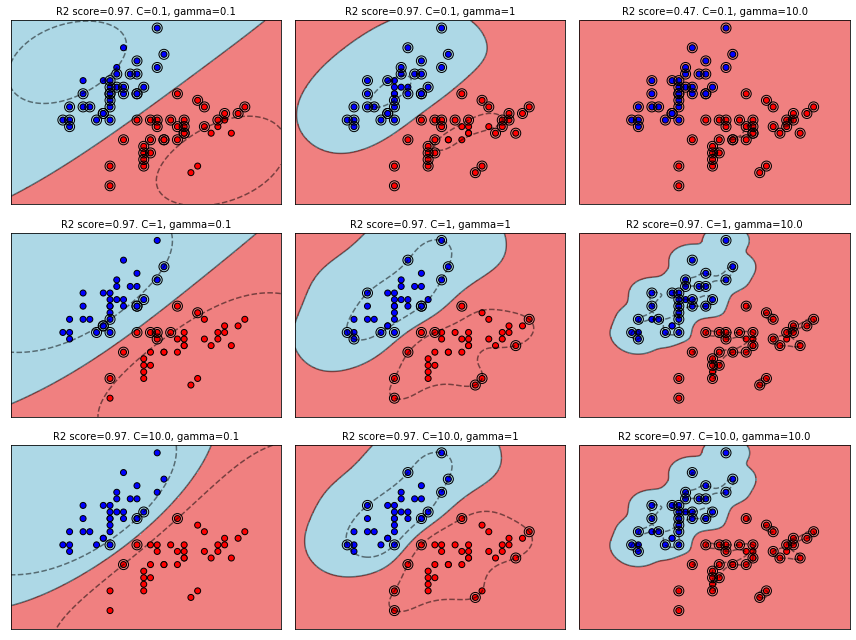

In [5]:
C_range = [1e-1, 1, 1e1]
gamma_range = [1e-1, 1, 1e1]
visualizer = SvmVisualizer(X_train, y_train, X_test, y_test, 3, 3)
k = 0

for C in C_range:
    for gamma in gamma_range:
        clf = svm.SVC(C=C, gamma=gamma, kernel="rbf", random_state=8)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        title = f"R2 score={score:.2f}. C={C}, gamma={gamma}"
        visualizer.add_svm_plot(clf, title, k)
        k += 1


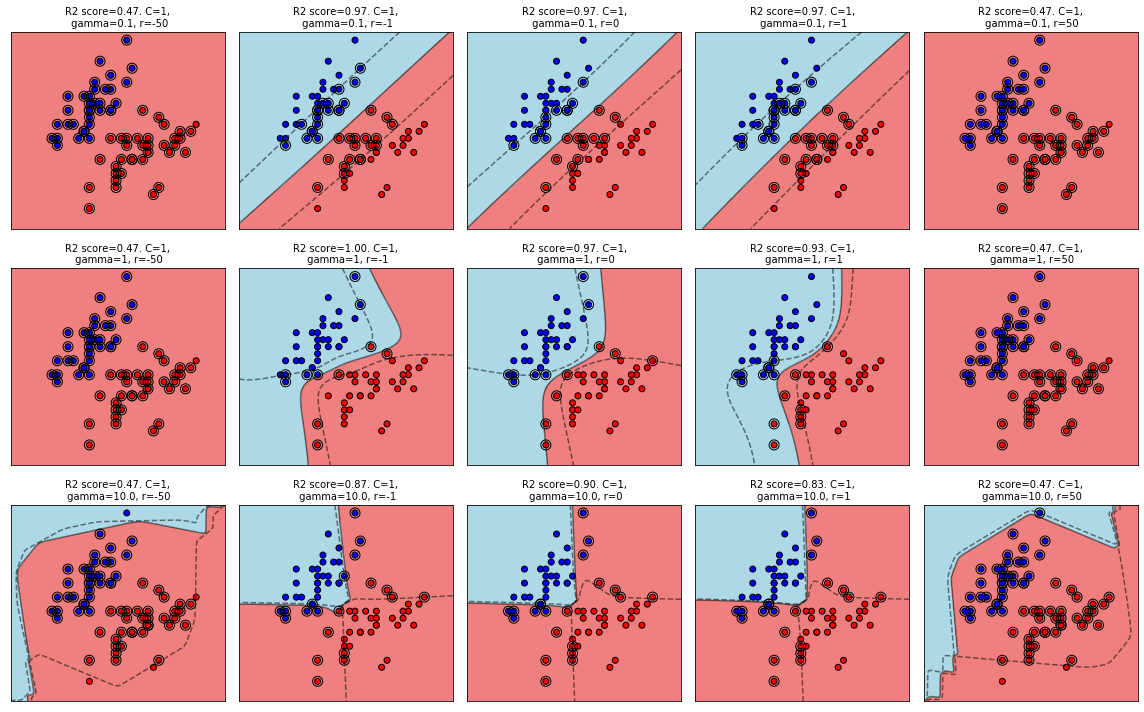

In [6]:
C_range = [1]
gamma_range = [1e-1, 1, 1e1]
coef0_range = [-50, -1, 0, 1, 50]
visualizer = SvmVisualizer(X_train, y_train, X_test, y_test, 3, 5, figsize=(16, 10))
k = 0

for C in C_range:
    for gamma in gamma_range:
        for coef0 in coef0_range:
            clf = svm.SVC(C=C, gamma=gamma, coef0=coef0, kernel="sigmoid", random_state=8)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            title = f"R2 score={score:.2f}. C={C},\n gamma={gamma}, r={coef0}"
            visualizer.add_svm_plot(clf, title, k)
            k += 1


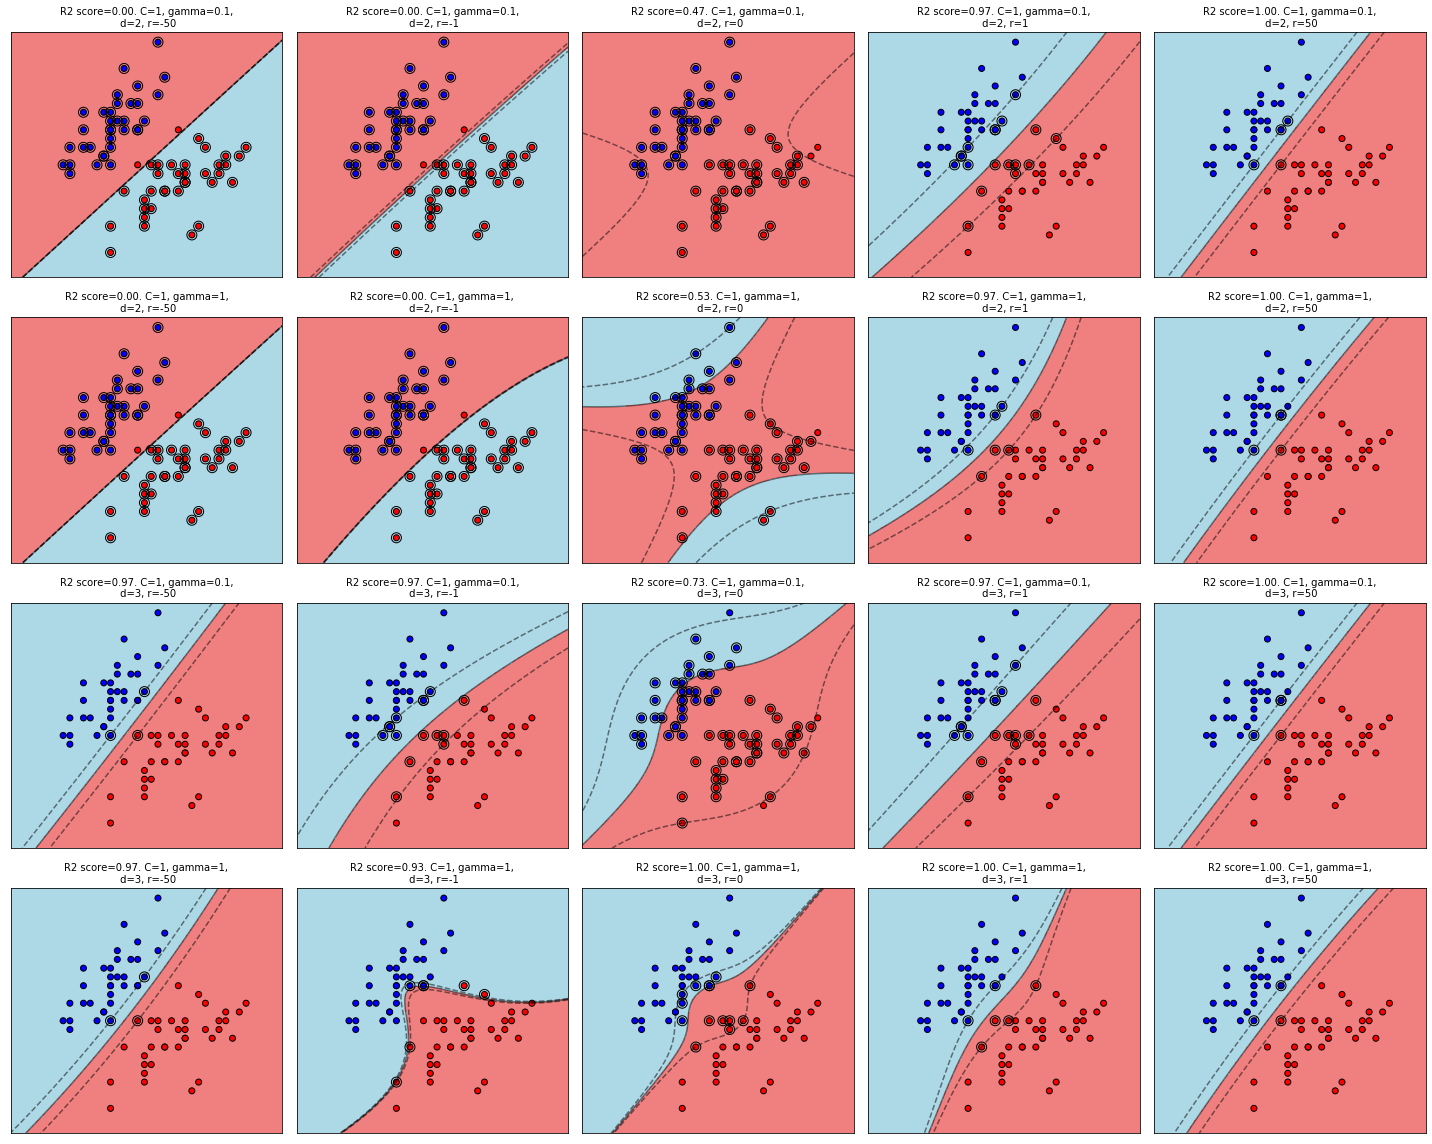

In [7]:
C_range = [1]
gamma_range = [0.1, 1]
degree_range = [2, 3]
coef0_range = [-50, -1, 0, 1, 50]
visualizer = SvmVisualizer(X_train, y_train, X_test, y_test, 4, 5, figsize=(20, 16))
k = 0

for C in C_range:
    for degree in degree_range:
        for gamma in gamma_range:
            for coef0 in coef0_range:
                clf = svm.SVC(C=C, gamma=gamma, degree=degree, coef0=coef0, kernel="poly", random_state=8)
                clf.fit(X_train, y_train)
                score = clf.score(X_test, y_test)
                title = f"R2 score={score:.2f}. C={C}, gamma={gamma},\n d={degree}, r={coef0}"
                visualizer.add_svm_plot(clf, title, k)
                k += 1